In [29]:
import pandas as pd

In [30]:
data = pd.read_csv("output.csv", sep=",")
data = data.drop(columns=['date', 'likes'])
data.head()

,username,title,start,end,com
0,Robert S,"Flying the Unfriendly Skies of Air France, and...",Denver,"- Stockholm, International]",Where to begin!!!! Denver to Paris flight on A...
1,Sophia T,Missed connection because of the airline’s fau...,Washington DC,"- Porto, International]",My first flight from DC to Paris got delayed b...
2,Khaoula M,Fantastic Service and Entertainment on My Long...,Tunis,"- Miami, International]",I recently flew with Air France from Tunisia t...
3,Dougie,Disorganised airline],Edinburgh,"- Valletta, Europe]","Rubbish organisation, missed connection due to..."
4,Arash C,Air France Business crew are very rude to othe...,Paris,"- Miami, International]",Rude Cabin Chef AF092.Rude Cabin Chef and crew...


In [31]:
print(f"Taille de data : {len(data)}")
data = data.dropna(how='any')
print(f"Taille de data : {len(data)}")

Taille de data : 12910
Taille de data : 12895


In [32]:
data['end_'] = data['end'].apply(lambda x: x.split(',')[0])
data = data.drop(columns=['end'])
data['end'] = data['end_'].apply(lambda x: x.split('- ')[1])
data = data.drop(columns=['end_'])
data.head()

,username,title,start,com,end
0,Robert S,"Flying the Unfriendly Skies of Air France, and...",Denver,Where to begin!!!! Denver to Paris flight on A...,Stockholm
1,Sophia T,Missed connection because of the airline’s fau...,Washington DC,My first flight from DC to Paris got delayed b...,Porto
2,Khaoula M,Fantastic Service and Entertainment on My Long...,Tunis,I recently flew with Air France from Tunisia t...,Miami
3,Dougie,Disorganised airline],Edinburgh,"Rubbish organisation, missed connection due to...",Valletta
4,Arash C,Air France Business crew are very rude to othe...,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami


In [33]:
data['trajet'] = data['start'] + "-" + data['end']
data.head()

,username,title,start,com,end,trajet
0,Robert S,"Flying the Unfriendly Skies of Air France, and...",Denver,Where to begin!!!! Denver to Paris flight on A...,Stockholm,Denver-Stockholm
1,Sophia T,Missed connection because of the airline’s fau...,Washington DC,My first flight from DC to Paris got delayed b...,Porto,Washington DC-Porto
2,Khaoula M,Fantastic Service and Entertainment on My Long...,Tunis,I recently flew with Air France from Tunisia t...,Miami,Tunis-Miami
3,Dougie,Disorganised airline],Edinburgh,"Rubbish organisation, missed connection due to...",Valletta,Edinburgh-Valletta
4,Arash C,Air France Business crew are very rude to othe...,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami,Paris-Miami


In [34]:
from textblob import TextBlob

def analyser_sentiment(commentaire):
    return TextBlob(commentaire).sentiment.polarity

data['sentiment'] = data['com'].apply(analyser_sentiment)
data.head()

,username,title,start,com,end,trajet,sentiment
0,Robert S,"Flying the Unfriendly Skies of Air France, and...",Denver,Where to begin!!!! Denver to Paris flight on A...,Stockholm,Denver-Stockholm,-0.055726
1,Sophia T,Missed connection because of the airline’s fau...,Washington DC,My first flight from DC to Paris got delayed b...,Porto,Washington DC-Porto,0.024731
2,Khaoula M,Fantastic Service and Entertainment on My Long...,Tunis,I recently flew with Air France from Tunisia t...,Miami,Tunis-Miami,0.453333
3,Dougie,Disorganised airline],Edinburgh,"Rubbish organisation, missed connection due to...",Valletta,Edinburgh-Valletta,-0.062500
4,Arash C,Air France Business crew are very rude to othe...,Paris,Rude Cabin Chef AF092.Rude Cabin Chef and crew...,Miami,Paris-Miami,-0.212500


In [43]:
tendances_trajets = data.groupby('trajet').agg(sentiment_moyen=('sentiment', 'mean'), nombre_commentaires=('sentiment', 'size')).reset_index()
tendances_trajets = tendances_trajets[tendances_trajets['nombre_commentaires'] > 10]
tendances_trajets = tendances_trajets.sort_values(by='sentiment_moyen')
print(tendances_trajets)

                    trajet  sentiment_moyen  nombre_commentaires
2518        Paris-San Jose        -0.102587                   14
1667       Mahebourg-Paris        -0.011755                   25
2456           Paris-Milan        -0.004865                   25
1494      London-Mahebourg         0.000406                   13
1260        Istanbul-Paris         0.003764                   16
...                    ...              ...                  ...
546        Bucharest-Paris         0.299645                   31
1130       Guangzhou-Paris         0.300588                   11
2663  Rio de Janeiro-Paris         0.303537                   34
2841           Seoul-Paris         0.309820                   13
280           Beirut-Paris         0.354941                   16

[189 rows x 3 columns]


In [27]:
nombre_trajets_uniques = data['trajet'].nunique()
print(f"Nombre de trajets différents : {nombre_trajets_uniques}")

Nombre de trajets différents : 3335


In [40]:
a, b = data['start'].nunique(), data['end'].nunique()
print(a, b)

356 372


In [44]:
tendances_start = data.groupby('start').agg(sentiment_moyen=('sentiment', 'mean'), nombre_commentaires=('sentiment', 'size')).reset_index()
tendances_start = tendances_start[tendances_start['nombre_commentaires'] > 10]
tendances_start = tendances_start.sort_values(by='sentiment_moyen')
print(tendances_start)

              start  sentiment_moyen  nombre_commentaires
96           Dallas        -0.017507                   36
151        Istanbul        -0.011158                   31
273         Raleigh         0.003726                   11
65           Cancun         0.008865                   23
12            Amman         0.015368                   28
..              ...              ...                  ...
133       Guangzhou         0.244346                   15
296           Seoul         0.257261                   19
53        Bucharest         0.267548                   54
167            Kyiv         0.287990                   25
276  Rio de Janeiro         0.297552                   49

[116 rows x 3 columns]


In [49]:
tendances_end = data.groupby('end').agg(sentiment_moyen=('sentiment', 'mean'), nombre_commentaires=('sentiment', 'size')).reset_index()
tendances_end = tendances_end[tendances_end['nombre_commentaires'] > 10]
tendances_end = tendances_end.sort_values(by='sentiment_moyen')
print(tendances_end)

                  end  sentiment_moyen  nombre_commentaires
10            Algiers         0.011059                   15
75   Chennai (Madras)         0.015449                   15
349             Tunis         0.018732                   32
301          San Jose         0.026506                   39
138          Helsinki         0.029237                   13
..                ...              ...                  ...
258       Panama City         0.242192                   23
311          Shanghai         0.244734                   47
208       Mexico City         0.250729                   71
259           Papeete         0.288511                   74
32            Beijing         0.290066                   31

[124 rows x 3 columns]


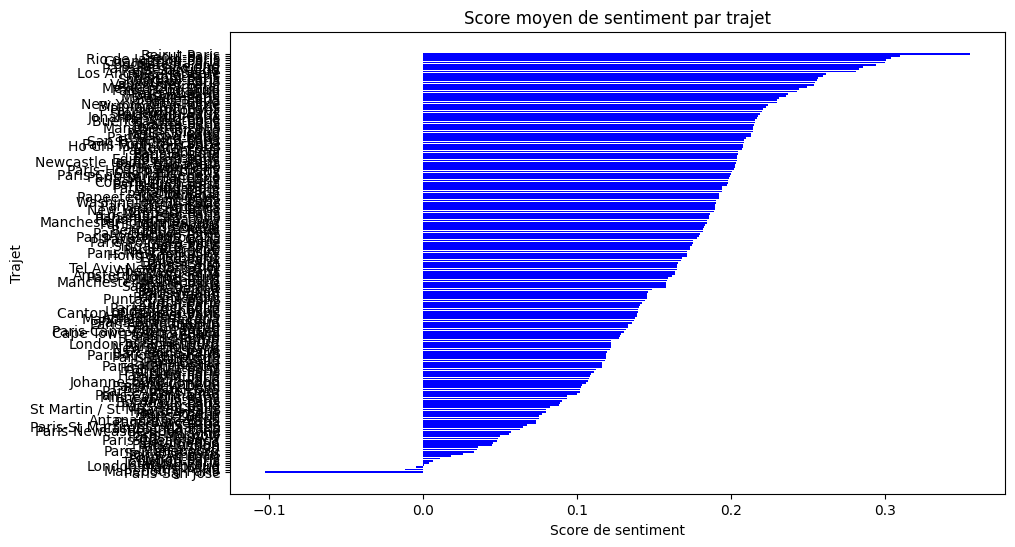

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(tendances_trajets['trajet'], tendances_trajets['sentiment_moyen'], color='blue')
plt.title("Score moyen de sentiment par trajet")
plt.xlabel("Score de sentiment")
plt.ylabel("Trajet")
plt.show()

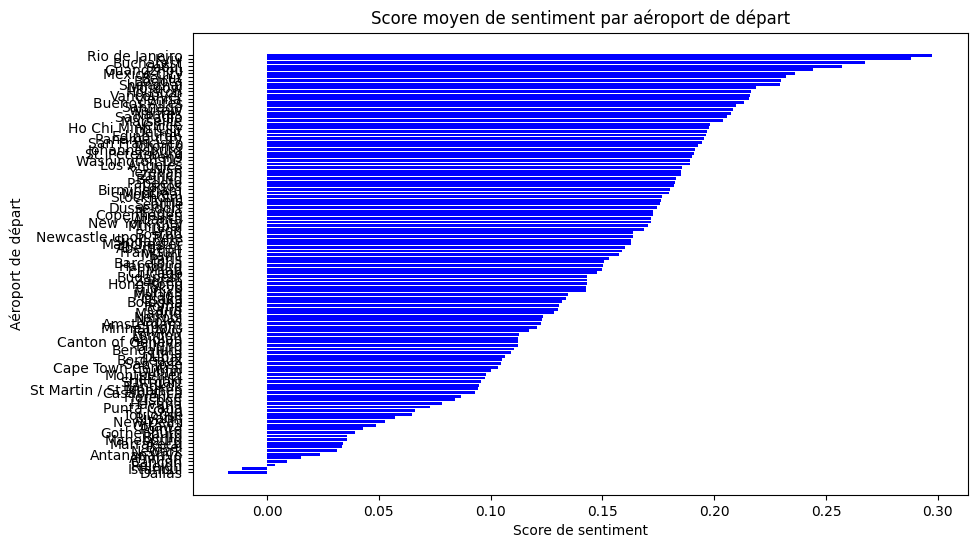

In [51]:
plt.figure(figsize=(10, 6))
plt.barh(tendances_start['start'], tendances_start['sentiment_moyen'], color='blue')
plt.title("Score moyen de sentiment par aéroport de départ")
plt.xlabel("Score de sentiment")
plt.ylabel("Aéroport de départ")
plt.show()

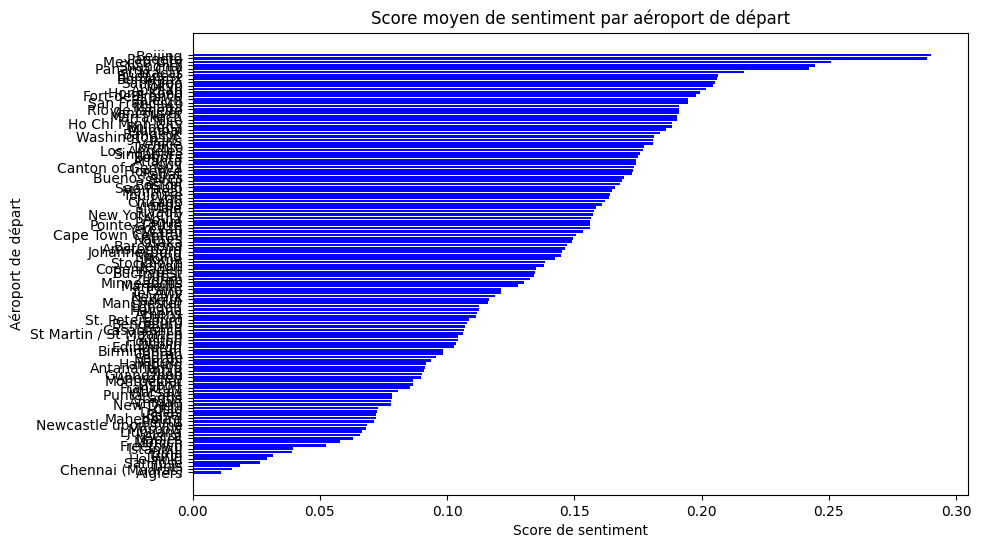

In [52]:
plt.figure(figsize=(10, 6))
plt.barh(tendances_end['end'], tendances_end['sentiment_moyen'], color='blue')
plt.title("Score moyen de sentiment par aéroport de départ")
plt.xlabel("Score de sentiment")
plt.ylabel("Aéroport de départ")
plt.show()

In [ ]:
from transformers import pipeline

analyse_sentiments = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
data['sentiment_analysis'] = data['commentaire'].apply(lambda x: analyse_sentiments([x])[0])
data['sentiment_label'] = data['sentiment_analysis'].apply(lambda x: x['label'])
data['sentiment_score'] = data['sentiment_analysis'].apply(lambda x: x['score'])
print(data[['commentaire', 'sentiment_label', 'sentiment_score']].head())
